### 读取基本数据

In [25]:
import pandas as pd

df = pd.read_csv('data.csv')
df = df[['城市','甜品饮品店']]
df.columns = ['city', 'amount']
df.head()

,city,amount
0,成都市,21306.0
1,重庆市,14461.0
2,上海市,12632.0
3,广州市,12544.0
4,深圳市,9366.0


### 检验高德api
- 首先需要取高德开放平台获取api key, 绑定key类型为Web服务

In [ ]:
import poi_api
import os

API_KEY = os.getenv('gaode_api') # 环境变量里设置好高德开放平台apikey,或者把获取的key用字符串形式赋值给API_KEY亦可

poi_getter = poi_api.AmapGeocoder(API_KEY)

# api 测试
coordinates = poi_getter.get_coordinates('内江市')

print(coordinates)

(105.057992, 29.58021)


### 数据集地理信息

In [ ]:
import time

def mapcity(city):
    time.sleep(0.5) # 设置延时，不然会被高德ban
    return poi_getter.get_coordinates(city)

df['coords'] = df['city'].apply(mapcity)

df


网络请求异常：HTTPSConnectionPool(host='restapi.amap.com', port=443): Max retries exceeded with url: /v3/geocode/geo?key=680dd693a891bc0a4da22febc5f2df69&address=%E6%B2%B3%E6%B1%A0%E5%B8%82 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001877F3B4B90>, 'Connection to restapi.amap.com timed out. (connect timeout=10)'))


,city,amount,coords
0,成都市,21306.0,"(104.066301, 30.572961)"
1,重庆市,14461.0,"(106.550483, 29.563707)"
2,上海市,12632.0,"(121.473667, 31.230525)"
3,广州市,12544.0,"(113.264499, 23.130061)"
4,深圳市,9366.0,"(114.057939, 22.543527)"
...,...,...,...
362,昆玉市,1.0,"(79.270193, 37.215372)"
363,三沙市,0.0,"(112.338649, 16.831004)"
364,北屯市,0.0,"(87.834419, 47.326733)"
365,双河市,0.0,"(82.353656, 44.840524)"


In [ ]:
df.dropna(inplace=True)

def getLon(coor):
    return coor[0]
def getLat(coor):
    return coor[1]

df['Lon'] = df['coords'].apply(getLon)
df['Lat'] = df['coords'].apply(getLat)

df

,city,amount,coords,Lon,Lat
0,成都市,21306.0,"(104.066301, 30.572961)",104.066301,30.572961
1,重庆市,14461.0,"(106.550483, 29.563707)",106.550483,29.563707
2,上海市,12632.0,"(121.473667, 31.230525)",121.473667,31.230525
3,广州市,12544.0,"(113.264499, 23.130061)",113.264499,23.130061
4,深圳市,9366.0,"(114.057939, 22.543527)",114.057939,22.543527
...,...,...,...,...,...
361,铁门关市,3.0,"(85.670291, 41.862997)",85.670291,41.862997
362,昆玉市,1.0,"(79.270193, 37.215372)",79.270193,37.215372
363,三沙市,0.0,"(112.338649, 16.831004)",112.338649,16.831004
364,北屯市,0.0,"(87.834419, 47.326733)",87.834419,47.326733


### 计算LISA&绘制热图
- 请自行优化显示效果
- 此处仅提供一个ai给出的示例

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.weights import KNN
from esda.moran import Moran_Local
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
# 加载中国省级地图并转换为投影坐标系
print("加载地理数据...")
china = gpd.read_file("https://geo.datav.aliyun.com/areas_v3/bound/100000_full.json") 
china_projected = china.to_crs('EPSG:3395') 

加载地理数据...


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


In [ ]:
geometry = gpd.points_from_xy(df.Lon, df.Lat)
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')  
gdf_projected = gdf.to_crs('EPSG:3395') 

In [ ]:
print("构建空间权重矩阵...")
knn = KNN.from_dataframe(gdf_projected, k=8)
knn.transform = 'r'  # 行标准化

构建空间权重矩阵...


In [38]:
print("计算LISA...")
moran_loc = Moran_Local(gdf_projected['amount'], knn)

# 将结果添加到GeoDataFrame
gdf_projected['local_moran'] = moran_loc.Is
gdf_projected['p_value'] = moran_loc.p_sim
gdf_projected['quadrant'] = moran_loc.q

# 标记显著性聚类（显著性水平0.05）
sig = 0.05
gdf_projected['significant'] = gdf_projected['p_value'] < sig

计算LISA...


In [39]:
# 根据象限和显著性分类
gdf_projected['cluster'] = np.where(
    gdf_projected['significant'], 
    gdf_projected['quadrant'], 
    0  # 不显著的标记为0
)
cluster_labels = {
    0: '不显著',
    1: '高-高',
    2: '低-高',
    3: '低-低',
    4: '高-低'
}
gdf_projected['cluster_label'] = gdf_projected['cluster'].map(cluster_labels)

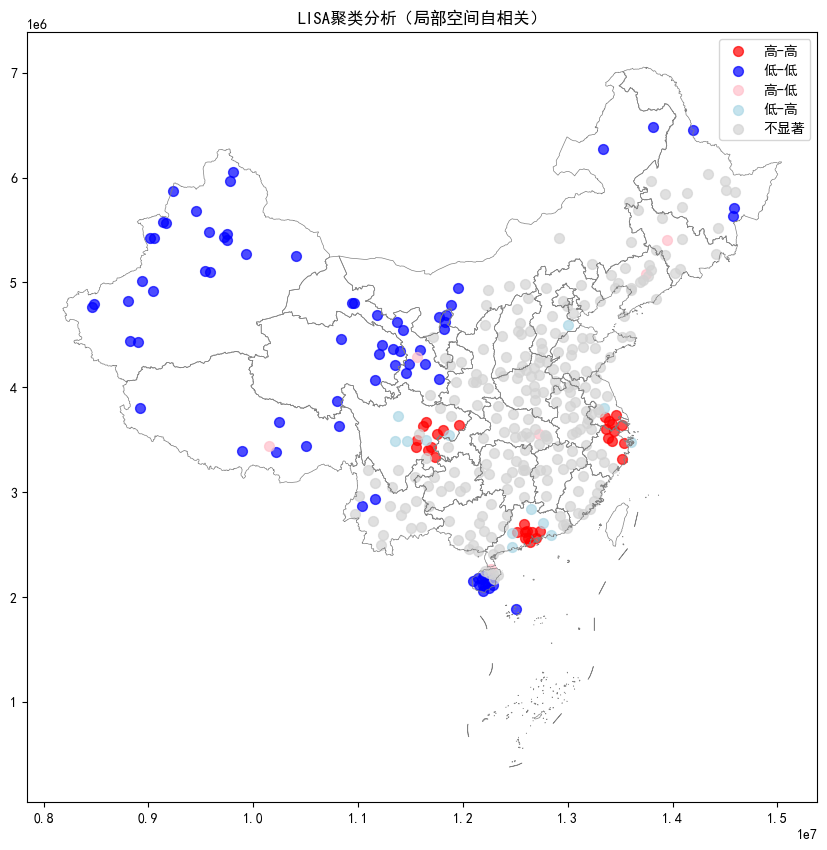

In [ ]:
colors = {
    '高-高': 'red',
    '低-低': 'blue',
    '高-低': 'pink',
    '低-高': 'lightblue',
    '不显著': 'lightgrey'
}

fig, ax = plt.subplots(figsize=(15, 10))
china_projected.boundary.plot(ax=ax, linewidth=0.5, color='gray')  

for label, color in colors.items():
    subset = gdf_projected[gdf_projected['cluster_label'] == label]
    if not subset.empty:
        subset.plot(ax=ax, color=color, markersize=50, label=label, alpha=0.7)

ax.set_title("LISA聚类分析（局部空间自相关）")
plt.legend()
plt.show()